# Multiclass Classification of Images using CNNs

## Programming Assignment 4 (PA4)

In PA4, you will classify images of handwritten digits using CNNs. The dataset used is the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

**IMPORTANT**: Use Google CoLab for running your code. This should speed up your training time, which will make everything easier! **THIS NOTEBOOK IS VIEW ONLY. To copy it so you can edit, it, go to `File -> Save a Copy in Drive`**.

**ENABLING GPU**: Simply upload the assignment notebook to your Google Drive, and open it with Google CoLab. Make sure to select GPU in the settings for CoLab. This can be done by going to

`runtime->change runtime type->Hardware Accelerator->GPU`

The notebook is broken into the following sections:
1. Loading MNIST (no ACT's)
2. Building the CNN
3. Building the Trainer
4. Training the Network
5. Network Accuracy
6. Visualizing CNN Layers
7. Comparing with a Fully Connected Network

### New Python concepts
In addition to Python concepts seen so far, this assignment requires the following **new** knowledge:
- Classes
  - *Stanford CS231n Python Numpy Tutorial*: "Classes" section [[link](https://cs231n.github.io/python-numpy-tutorial/#classes)]
  - *GeeksforGeeks* tutorial on Python [objects](https://www.geeksforgeeks.org/python-classes-and-objects/) and [classes](https://www.geeksforgeeks.org/creating-instance-objects-in-python/)

If you're new to Python, we recommend you briefly learn the basics of the above before starting the assignment.

### General Hints
- See precept materials for more details on how to use PyTorch modules.
- Read all the code in a cell first and understand its structure before filling in code statements for that cell.

### A Note on GPU Runtime
For this assignment, we encourage you to use GPU run time for ACT 16 (Training the network) onwards. By using a GPU, the code related to training and evaluating your `ConvNet` network will execute much more quickly.

By using a Colab notebook, you have 12 hours of access to a GPU (as mentioned in the Google Colab [FAQ](https://research.google.com/colaboratory/faq.html) section).

To conserve as much GPU run time as possible for ACT 16 onwards, we encourage you to complete ACT 1-15 with the `Hardware Accelerator` set to `CPU`.

Before starting ACT 19, we then encourage you to set `Hardware Accelerator` to `T4 GPU`. Then, re-run ACT 1-15 before starting on ACT 16, as changing the `Hardware Accelerator` will reset the notebook runtime.

The `Hardware Accelerator` option can be found by clicking the `Edit` tab, then `Notebook settings`.

With that said, if you have run out of GPU run time, the assignment can still be completed without it. The following sections will likely take longer to execute (minutes versus seconds).

Please budget your GPU run time accordingly, as no extensions or late exceptions will be made due to GPU access issues.

### Assignment submission

 This assignment is to be uploaded as both a .ipynb file and a converted .pdf file **via Gradescope**. For help converting the notebook to a .pdf file, see [this document](https://bit.ly/cos324-colab-pdf). You can submit as often as you need, but only the last submission is graded, and submissions made after the deadline may incur a late penalty depending on your remaining free late hours.
### Collaboration statement

List all collaborators by name, including other students and/or course staff (e.g. TAs, UCAs). If you collaborated with no one on this assignment, write the following: ``"I did not collaborate with anyone on this assignment."``

**TODO: ADD COLLABATION STATEMENT HERE: I did not collaborate with anyone on this assignment.**

In [ ]:
!pip install torchviz

In [ ]:
# Setting some hyperparameters and making sure we have a GPU
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import tqdm
import os
from google.colab import files
from torchviz import make_dot

# Set the device to use
device = torch.device("cpu")

# We encourage you to complete ACT 1-15 using a CPU, then switching to GPU upon beginning ACT 16
# If you'd like to use a GPU instead of a CPU to run the following code, you can uncomment the following line
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 10
num_classes = 10  # there are 10 digits: 0 to 9
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# This line prints out the type of device you will run the notebook in.
print(str(device))

cpu


### Loading MNIST
Here we are loading the MNIST dataset. This dataset consists of 60,000 training images and 10,000 test images.

Each image is a 28-by-28 grayscale image, so it is represented by a 28-by-28 array. The labels are 0 to 9, representing digits 0-9.

In [ ]:
from torch.utils.data import DataLoader

# transforms to apply to the data, converting the data to PyTorch tensors and normalizing the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=trans)

# train_loader returns batches of training data. See how train_loader is used in the Trainer class later
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,num_workers=0)

##ASSERTS: checking whether the data is loaded as expected
assert(len(train_loader)*batch_size >= 60000)
assert(len(test_loader)*batch_size >=10000)

Now we visualize some samples from the dataset.

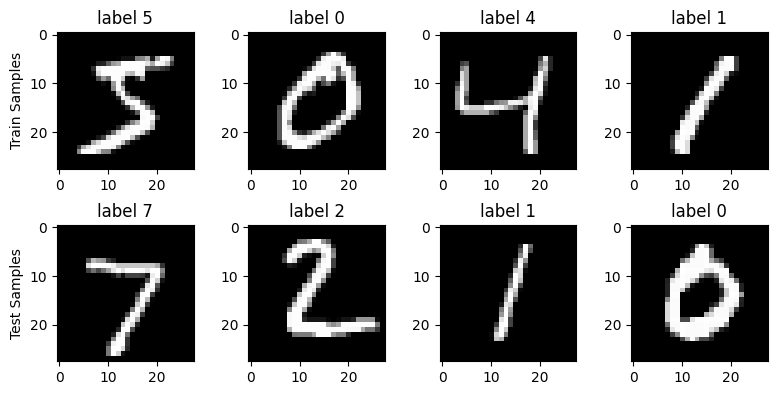

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for sample_idx in range(4):

    train_image, train_label = train_dataset[sample_idx]
    axs[0, sample_idx].imshow(train_image.squeeze(0), cmap='grey')
    axs[0, sample_idx].set_title(f"label {train_label}")

    test_image, test_label = test_dataset[sample_idx]
    axs[1, sample_idx].imshow(test_image.squeeze(0), cmap='grey')
    axs[1, sample_idx].set_title(f"label {test_label}")

axs[0, 0].set_ylabel("Train Samples")
axs[1, 0].set_ylabel("Test Samples")
plt.tight_layout()
plt.show()

ACT 0: What is the size of the input samples?

In [ ]:
input_shape = train_image.size()
print(input_shape)

torch.Size([1, 28, 28])


### Building the network
Let's build a CNN to classify MNIST images. You will build a CNN with the following architecture:

Input:
0. The input is a 3-dimensional array with size you have seen in ACT 0.

Network:
1.   `conv1`: 2D Convolutional Layer with 16 output channels, 5-by-5 kernels, **and padding of size 2**, activation function RELU
2.   `pool1`: Max Pooling with a 2-by-2 kernel and a stride of size 2
3.   `conv2`: 2D Convolutional Layer with 32 output channels, 5-by-5 kernels, **and no padding**, activation function RELU
4.   `pool2`: Max Pooling with a 2-by-2 kernel and a stride of size 2
5.   `fc1`: Fully Connected Layer with output size 120 with RELU activation
5.   `fc2`: Fully Connected Layer with output size 84 with RELU activation
6.   `fc3`: Fully Connected Layer with output of size 10 (no activation function)

This is very similar to one of the first convolutional neural networks in the world developed by Yann Lecun et. al. Fore more details, see the [LeNet-5 paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) or the [Wikipedia page](https://en.wikipedia.org/wiki/LeNet). It used to take several days to train this model on a non-parallel 200MHz CPU.

ACTS 1-9 require you to fill in the blank code statements in the cell below.

**Hint:** See `torch.nn` [documentation](https://pytorch.org/docs/stable/nn.html).

For forward pass steps with `nn.Module` defined in initialization, use calls like `self.conv1(x)`. For forward pass steps without `nn.Module` defined in initialization (usually parameterless), use calls like `F.relu(x)`.

**Hint:** Print out the shape for the final output of `ConvNet`. You may also print out every intermediate shapes of `x` in the forward pass.  

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


### ACT1-ACT9:
### Complete the code below based on the architecture described above
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding = 2)
        self.pool1 = nn.MaxPool2d(2, stride = 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)

        # ACT5 compute the size of the the input for the first fully connected layer.
        # You can track what happens to a image when passes through the previous layers.
        # You will endup with 32 channels, each of size x-by-x,
        # therefore the size of input is (32*x*x) - you need to compute x and fill the code below
        self.size_linear = 32 * 5 * 5
        self.fc1 = nn.Linear(self.size_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) # we provide this line for you
        x = self.pool2(F.relu(self.conv2(x)))# ACT7: apply the second convolution and max pooling
        x = x.view(-1, self.size_linear) # ACT8: flatten x into a 1D vector (see https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view)
        x = F.relu(self.fc1(x)) # ACT9.1: Apply the first fc layer (with ReLU)
        x = F.relu(self.fc2(x)) # ACT9.2: Apply the second fc layer (with ReLU)
        x = self.fc3(x) # ACT9.3: Apply the last fully connected layer (no ReLU)
        return x

##ASSERT: checks if your CNN has the correct output shape
with torch.no_grad():  # tells PyTorch not to track gradients here
    # test_data is 54 random images
    test_data = torch.stack([train_dataset[i][0] for i in range(64)]).to(device)
    test_net = ConvNet().to(device)
    out = test_net.forward(test_data)
    print(out.shape)
    # the output should have size (64,10)
    assert(out.size()==(64,10))


torch.Size([64, 10])


Now we can check how many parameters are there in the model

In [ ]:
def count_parameters(model):
    total_params = 0
    for name, param in model.named_parameters():
        print(f"{name}:\t {param.shape}")
        total_params += len(param.view(-1))
    print(f"Total parameters: {total_params}")

count_parameters(ConvNet())

conv1.weight:	 torch.Size([16, 1, 5, 5])
conv1.bias:	 torch.Size([16])
conv2.weight:	 torch.Size([32, 16, 5, 5])
conv2.bias:	 torch.Size([32])
fc1.weight:	 torch.Size([120, 800])
fc1.bias:	 torch.Size([120])
fc2.weight:	 torch.Size([84, 120])
fc2.bias:	 torch.Size([84])
fc3.weight:	 torch.Size([10, 84])
fc3.bias:	 torch.Size([10])
Total parameters: 120382


### Visualize Your Network

**ACT10**

Use the `made_dot()` function from `torchvis` to visualize your network. This will build the computation graph/tree that computes `out` based on elements in `params`. Fill in the value for `params`.

Check [pytorchviz package](https://github.com/szagoruyko/pytorchviz#usage) or [pytorchviz examples](https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb) for more details.

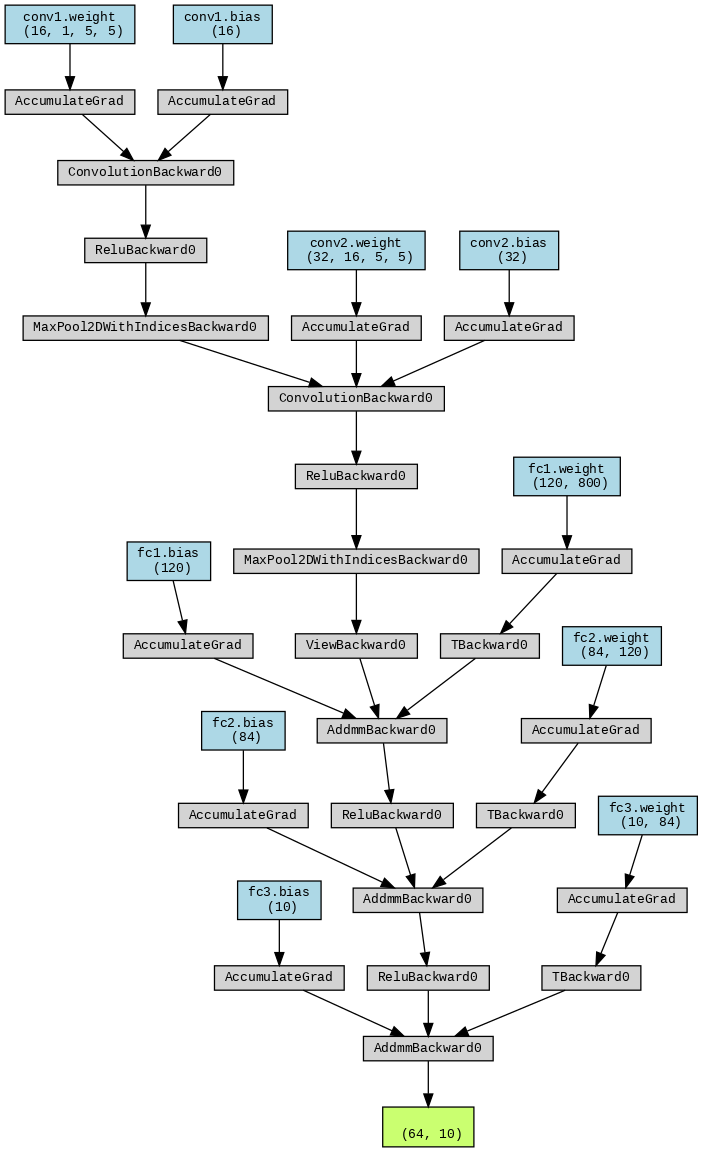

In [ ]:
from IPython.display import Image

test_data = torch.stack([train_dataset[i][0] for i in range(64)])
test_net = ConvNet()
out = test_net.forward(test_data)
params = dict(test_net.named_parameters())
dot = make_dot(out, params=params)
dot.format = "png"
dot.render(filename="network_graph")
Image(filename="network_graph.png")

### Preparing for training: Build accuracy checker

Torch has built-in function to compute the cross entropy loss using the logits output from networks (e.g. `nn.CrossEntropyLoss()`). However there is not an native implementation for checking classification accuracy.

Here you will need to implement an accuracy function which takes in a 2D array of logits with shape (batchsize, n_class) and a 1D array of ground truth labels (integers from 0 to n_class-1) with shape (batchsize). Your accuracy function should output the percentage of the samples in the batch such that the argmax of the logits equals to the ground truth label.

In [ ]:
def compute_accuracy(logits, labels):
    # Act11 - Implement the accuracy function
    predicted_label = torch.argmax(logits, dim = 1)
    correct = len(predicted_label[predicted_label == labels])
    accuracy = correct / len(labels)
    return accuracy

# Your function should pass the following assertion
test_logits = torch.eye(10)
labels = torch.arange(10)
labels[-3:] = 1
assert compute_accuracy(test_logits, labels) == 0.7

### Building the trainer
To train our model, we'll build a Trainer class that holds our network and data. When we call

```
trainer.train(epochs)
```
The Trainer trains over all the data for *epochs* times.
In each epoch, the trainer will call method `train_epoch`, which iterate over batches in the dataloader for training set. For each batch, it will

1. Pass the batched input into the model and obtain the logit outputs.
2. Compute the loss and accuracy of the model logits with respect to the batches labels.
3. Use `loss.backward()` to compute the gradients for each trainable parameters.
4. Update the parameters using an optimizer (e.g. SGD).

After optimizing over the training set for this epoch, the trainer will call `test_epoch`, which will pass the test data through the model and check the generalization capabilities of the trained model.

Look at the cell below to see how we instantiate a trainer, and complete the Trainer code via the ACT's.

**Hints:**
- See `torch.optim` [documentation](https://pytorch.org/docs/stable/optim.html).
- Scroll to the next code cell to see what `loss_function` is set to and look at [documentation](https://pytorch.org/docs/stable/nn.html#loss-functions) for it.
- Each Act in `train_epoch` below requires only only one line of code. You need to write more code in `test_epoch`, but they should be derived from `train_epoch`
- When doing the testing, we do not need to compute the gradients, so you should use `with torch.no_grad():`. Please see [documentation](https://pytorch.org/docs/stable/generated/torch.no_grad.html) for examples.

In [ ]:
### ACT12-ACT18 Please fill the code below
class Trainer():
    def __init__(self,
                 net,
                 optimizer,
                 loss_function,
                 train_loader,
                 test_loader
                 ):

        self.net = net
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train_epoch(self):
        """
        This method takes one pass through the training dataloader
        """
        dataloader_progress = tqdm.tqdm(self.train_loader, desc='Training') # for progress bar display

        total_loss = 0.0
        total_accuracy = 0.0
        total_steps = 0.0

        for data in dataloader_progress:

            # Moving this batch to GPU
            # Note that X has shape (batch_size, number of channels, height, width)
            # which is equal to (256,1,28,28) since our default batch_size = 256 and
            # the image has only 1 channel
            X = data[0].to(device)
            y = data[1].to(device)

            # ACT12-Zero the gradient in the optimizer i.e. self.optimizer
            self.optimizer.zero_grad()

            # ACT13-Getting the output of the Network
            output = self.net(X)

            # ACT14-Computing loss using loss function i.e. self.loss_function
            loss = self.loss_function(output, y)

            # ACT15-Computing accuracy using the compute_accuracy function defined above
            accuracy = compute_accuracy(output, y)

            # ACT16-Backpropagate the loss to compute gradients of parameteres
            loss.backward()

            # ACT17-Call the optimizer i.e. self.optimizer
            self.optimizer.step()

            total_loss += loss.item()
            total_accuracy += accuracy
            total_steps += 1

            dataloader_progress.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{accuracy * 100:.2f}%"})

        epoch_loss = total_loss / total_steps
        epoch_accuracy = total_accuracy / total_steps

        return epoch_loss, epoch_accuracy

    def test_epoch(self):
        """
        This method takes one pass through the test dataloader
        Please write this method based on the train_epoch function you have created above
        When doing the modifications, keep the following things in mind

        1. We are not computing gradients (use with torch.no_grad())
        2. We are not using optimizers / taking optimizer steps
        """
        dataloader_progress = tqdm.tqdm(self.test_loader, desc='Testing')
        # ACT18: Write test_epoch function returning the average loss (epoch_loss) and accuracy (epoch_accuracy) over the test set

        total_loss = 0
        total_accuracy = 0
        steps = 0

        with torch.no_grad():

          for data in dataloader_progress:

              X = data[0].to(device)
              y = data[1].to(device)

              output = self.net(X) # forward pass

              loss = self.loss_function(output, y) # calculate loss

              accuracy = compute_accuracy(output, y) # calculate accuracy

              total_loss += loss.item() # calculate total loss
              total_accuracy += accuracy # calculate total accuracy
              steps += 1

          epoch_loss = total_loss / steps
          epoch_accuracy = total_accuracy / steps

          return epoch_loss, epoch_accuracy

    def train(self, epochs):

        # Initialize arrays to store the losses and accuracies
        stats = {
            'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': []
        }

        for epoch in tqdm.trange(epochs, disable=True):

            # Train the model over the training set and record the training loss / acc
            train_loss, train_acc = self.train_epoch()

            # Test the model over the testing set and record the testing loss / acc
            test_loss, test_acc = self.test_epoch()

            stats['train_loss'].append(train_loss)
            stats['test_loss'].append(test_loss)
            stats['train_acc'].append(train_acc)
            stats['test_acc'].append(test_acc)

            print(f"Epoch {epoch + 1}: train loss {train_loss:.4f}, train acc {100 * train_acc:.2f}%, test loss {test_loss:.4f}, test acc {100 * test_acc:.2f}%\n")

        return stats

### Training the network
Let's find the right learning rate. Test out training using various learning rates (you'll want to reinitialize the network each time you choose a new learning rate).

Your task is to find a learning rate that results in less than 0.03 loss after 10 epochs of training. When submitting the notebook, submit it with that learning rate value filled in for ACT16.

**NOTE**: At this point, if you have been running the notebook using `CPU` (i.e. with `Hardware Accelerator` set to `None`), we now encourage you to change the setting to `GPU` and re-run the notebook up to this point. Going forwards, your code will execute much more quickly if a GPU is enabled.

In [ ]:
import torch.optim as optim

### ACT19 try different learning rates for SGD to see which one works (do not try learning rates greater than 1)
### number of epochs is fixed at 10, do not change it
### we want the last epoch loss to be less than 0.03

learning_rate = 0.05

torch.manual_seed(324) # random seed for reproducibility

net = ConvNet()
net = net.to(device)
opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

trainer = Trainer(net, opt, loss_function, train_loader, test_loader)
stats = trainer.train(num_epochs)
###ASSERTS
assert(stats['train_loss'][-1] < 0.03)
assert(len(stats['train_loss'])==num_epochs)  # because you record the loss after each epoch

Testing: 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]


Epoch 1: train loss 0.5556, train acc 82.16%, test loss 0.0671, test acc 98.10%



Testing: 100%|██████████| 40/40 [00:06<00:00,  5.83it/s]


Epoch 2: train loss 0.0661, train acc 97.98%, test loss 0.0582, test acc 98.36%



Testing: 100%|██████████| 40/40 [00:06<00:00,  6.26it/s]


Epoch 3: train loss 0.0478, train acc 98.53%, test loss 0.0411, test acc 98.74%



Testing: 100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Epoch 4: train loss 0.0392, train acc 98.87%, test loss 0.0422, test acc 98.73%



Testing: 100%|██████████| 40/40 [00:06<00:00,  5.90it/s]


Epoch 5: train loss 0.0302, train acc 99.06%, test loss 0.0400, test acc 98.85%



Testing: 100%|██████████| 40/40 [00:06<00:00,  6.01it/s]


Epoch 6: train loss 0.0272, train acc 99.12%, test loss 0.0451, test acc 98.52%



Testing: 100%|██████████| 40/40 [00:06<00:00,  6.25it/s]


Epoch 7: train loss 0.0249, train acc 99.18%, test loss 0.0372, test acc 98.89%



Testing: 100%|██████████| 40/40 [00:06<00:00,  6.24it/s]


Epoch 8: train loss 0.0211, train acc 99.36%, test loss 0.0417, test acc 98.76%



Testing: 100%|██████████| 40/40 [00:06<00:00,  6.12it/s]


Epoch 9: train loss 0.0199, train acc 99.37%, test loss 0.0415, test acc 98.97%



Testing: 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]

Epoch 10: train loss 0.0149, train acc 99.53%, test loss 0.0403, test acc 98.84%



### Visualize and analyze training trajectory (ACT20)

Now that we have the training and testing statistics, we can do some visualization of the training trajectory. Please reproduce figure 5 in the [LeNet-5 Paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) for classification error rate (ACT19) and produce a similar figure for the training and testing loss (ACT 20).

Your reproduced figure does not have to match the exact format of Yann's figure in the paper, but it should come with two lines, legend, and proper axis names.

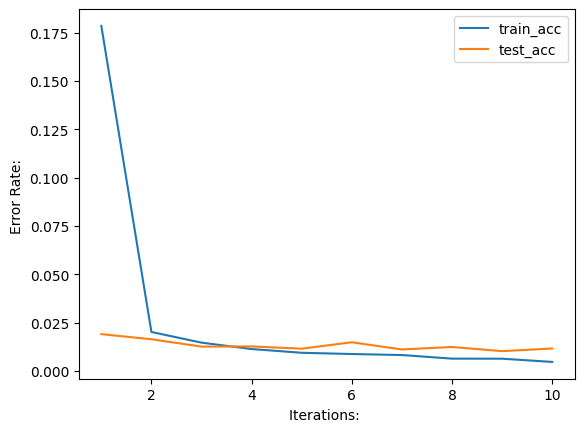

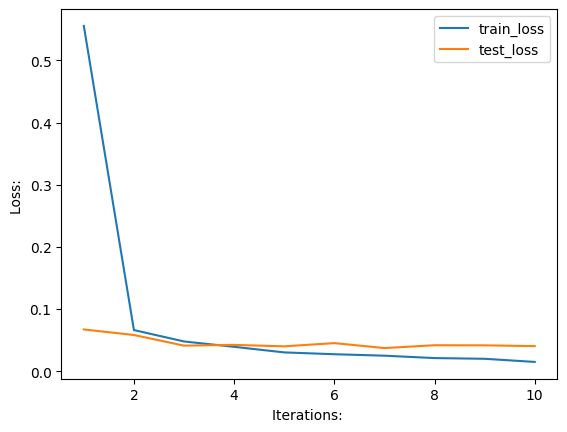

In [ ]:
 ### ACT20.1
# Reproduction of figure 5 in the LeNet-5 paper
plt.figure()
plt.xlabel("Iterations: ")
plt.ylabel("Error Rate: ")
iterations = np.arange(1, len(stats['train_loss']) + 1)

ones = np.ones(len(stats['train_loss']))
plt.plot(iterations, ones - stats['train_acc'], label = 'train_acc')
plt.plot(iterations, ones - stats['test_acc'], label = 'test_acc')
plt.legend()

### ACT20.2
# Same figure, but with loss on y-axis
plt.figure()
plt.xlabel("Iterations: ")
plt.ylabel("Loss: ")
plt.plot(iterations, stats['train_loss'], label = 'train_loss')
plt.plot(iterations, stats['test_loss'], label = 'test_loss')
plt.legend()

### Analyze training trajectory (ACT20.3)
In the two figures above (and also in figure 5 of the paper), it is possible that the training error rate / loss is higher than the testing error rate / loss at earlier stages of training. How should you make sense of this seemingly counter intuitive observation? Hint: which model is the loss being computed over?

Your answer: Yes because the training error rate / loss is computed after each iteration where the model is not optimized at the start which exhibits the high error rate.

### Inspecting Model Errors
**ACT 21**

For incorrectly classified samples, we want to check the probability the model assigned to each predictions. Please complete the code which takes in the model output of a single sample (logits) and compute the top-k (k=3 by default) possible labels assigned by the model and their corresponding softmax possibilities (value of the corresponding entries for the softmax output). (**ACT21**)

You may use `nn.functional.softmax` ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html)) to compute the softmax probability and use `torch.sort` to get the most possible entries along with their corresponding softmax probabilities.

In [ ]:
def sorted_softmax_prob(logits, topk=3):
    # Compute the softmax probabilities of the logits using torch.
    p_inds = F.softmax(logits, dim = 1).squeeze() # ACT21.1-Compute the softmax for the single sample logit
    top_p, top_inds = torch.sort(p_inds, descending = True) # ACT21.2-Sort the softmax distribution
    return top_p[:topk], top_inds[:topk]

# If your implementation is correct, you should pass the following test case
test_input = torch.tensor([[10,3,4,2,5,9,8]]).float()
top_p, top_inds = sorted_softmax_prob(test_input)
assert torch.linalg.norm(top_p - torch.tensor([0.6606, 0.2430, 0.0894])) <= 0.01, top_p
assert torch.sum(top_inds - torch.tensor([0, 5, 6])) <= 0.01, top_inds

**ACT22**

After implementing the `sorted_softmax_prob` function, call the function in the visualization script below to check the error

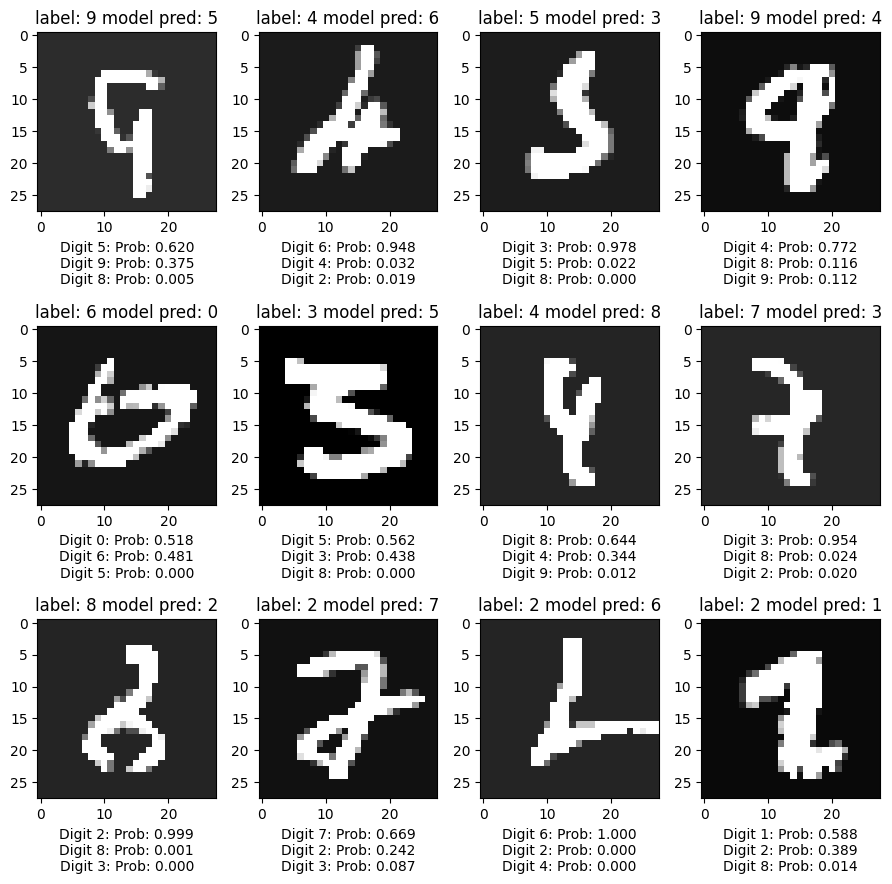

In [ ]:
def normalize_image(npimg):
    npimg = (npimg - np.mean(npimg)) / np.std(npimg)
    npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
    return npimg

num_to_check = 12
num_checked = 0
test_loader_for_error_analysis = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=0)
net.eval()

fig, axes = plt.subplots(3, 4, figsize=(9, 9))

with torch.no_grad():

    for data in test_loader_for_error_analysis:
        X = data[0].to(device)
        y = data[1].to(device)

        # Get the logit prediction from the model
        output = net(X)
        _, yh = torch.max(output, 1)

        if yh.item() != y.item():

            npimg = X[0][0].to('cpu').numpy()
            npimg = normalize_image(npimg)
            axes[num_checked // 4, num_checked % 4].imshow(npimg, cmap="gray", vmin=0, vmax=1)
            axes[num_checked // 4, num_checked % 4].set_title(f"label: {y.item()} model pred: {yh.item()}")

            top_p, top_inds = sorted_softmax_prob(output) # ACT22

            top_possibility_str = []
            for p, ind in zip(top_p, top_inds):
              top_possibility_str.append(f"Digit {ind}: Prob: {p:.3f}")
            axes[num_checked // 4, num_checked % 4].set_xlabel("\n".join(top_possibility_str))
            num_checked += 1

            if num_checked == num_to_check:
                break

plt.tight_layout()
plt.show()


**ACT 23**
Briefly describe what you observe when the model makes incorrect predictions. Is the model making obvious mistakes? Or is the data also tricky?

**ANSWER**: The data is also tricky and not exactly obvious as I would expect. For example, the 6 being misidentified as a 0 by the model is not suprising. Additionally, a lot of the 3s look like 5s and vice versa.

### Visualize CNN layers
Now you will visualize some internal values in the CNN. You will visualize the filters in the CNN and the result of applying those CNN filters to input images.

#### Visualize each filter separately in the first layer (ACT24)

* Our first layer was a 2d convolutional layer with 16 output channels and 5-by-5 kernel
* Therefore we have 16 different learnt filters. Each has size (1,5,5), so, each filter is a 5-by-5 array of weights
* Let's look at each filter as a 5-by-5 grayscale image and plot it


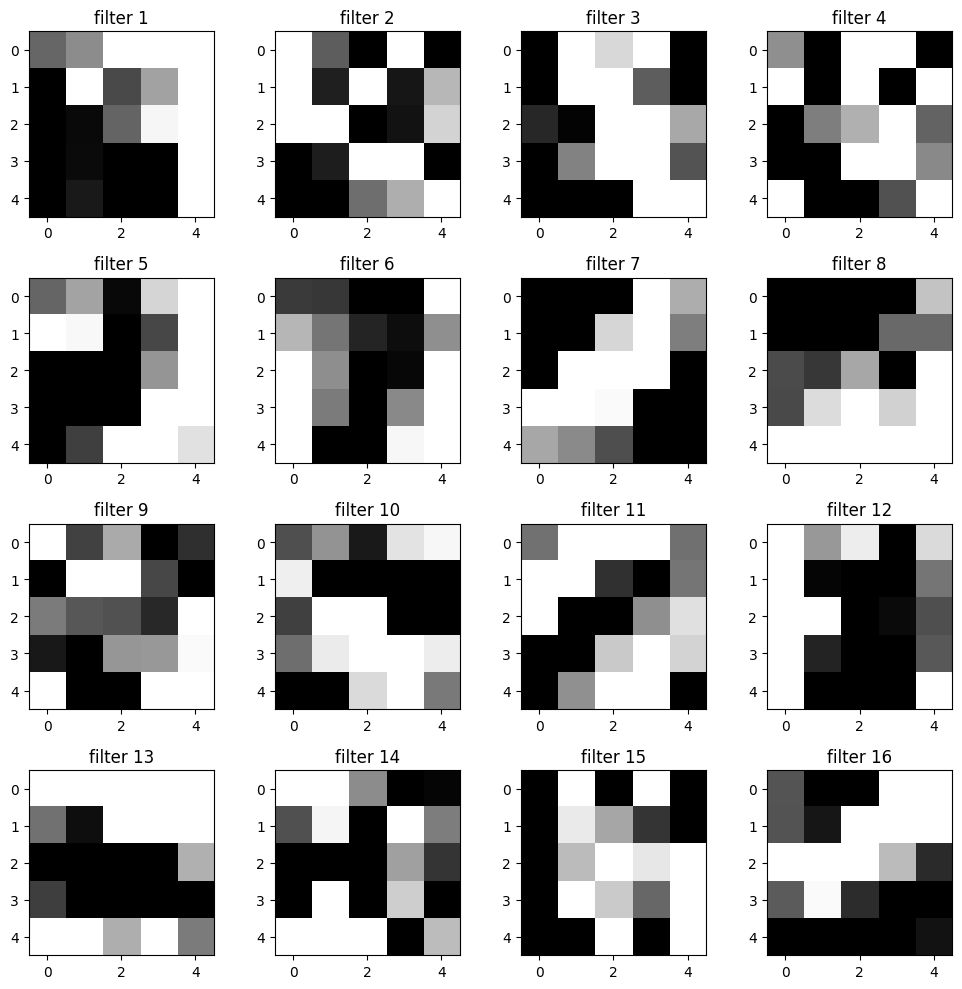

In [ ]:
### fill in the line of code below
### hint: start by looking the shape/size of net.conv1.weight
#print(net.conv1.weight.size())

plt.figure(figsize=(10,10))

# Enumerate all filters
for i in range(16):
    plt.subplot(4,4,i+1)
    npimg = net.conv1.weight[i].cpu().detach().numpy().squeeze() # ACT24
    # npimg should be a 5-by-5 numpy array corresponding to the i-th filter
    # if you need to move npimg off the GPU, you can use .cpu()
    # you should convert from PyTorch to Numpy in ACT21
    npimg = normalize_image(npimg)
    plt.imshow(npimg, cmap="gray", vmin=0, vmax=1)
    plt.title(f"filter {i + 1}")

plt.tight_layout()
plt.show()


After running this cell, answer the following question:


**ACT25:**

**Briefly explain what are these filters detecting. One to two sentences should be sufficient.**

**ANSWER**: These filters are detecting features like edges, cornors, and shape of the numbers.


### Visualize the input after applying the first layer (ACT 26-27)

*  First layer has 16 filters
*  Since padding is 2 and kernel is 5-by-5, each output channel will be again 28-by-28
*  Let's visualize each of these 16 pictures for one example of each digit

**Hint:** Use `net.conv1` to use the `conv1` module defined in the `ConvNet`.

In [ ]:
print(net.conv1)


Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))


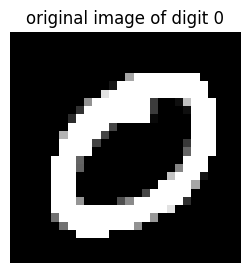

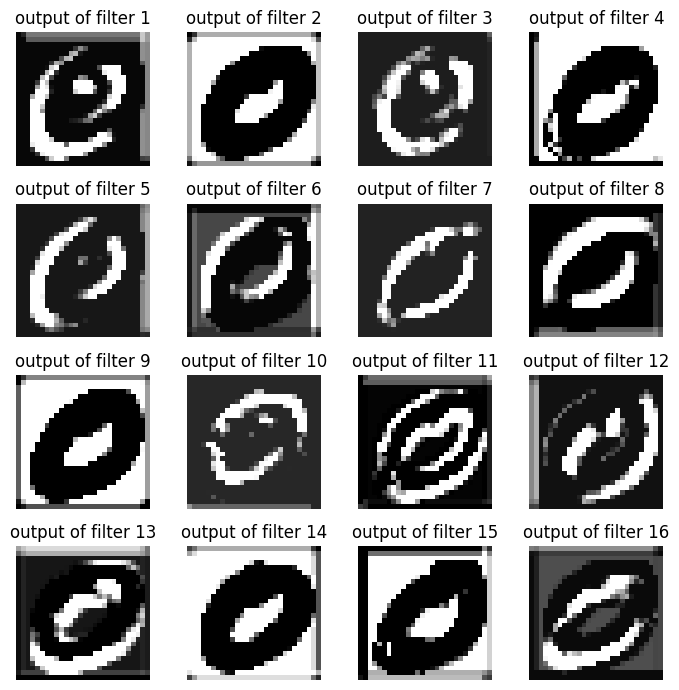

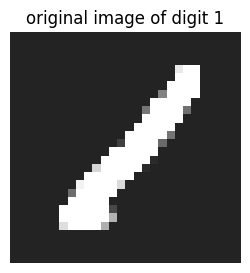

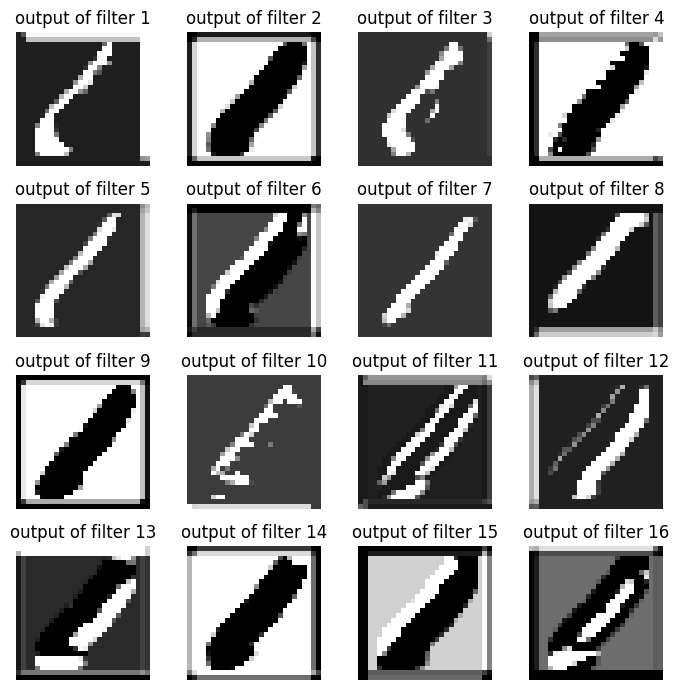

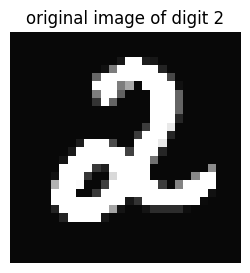

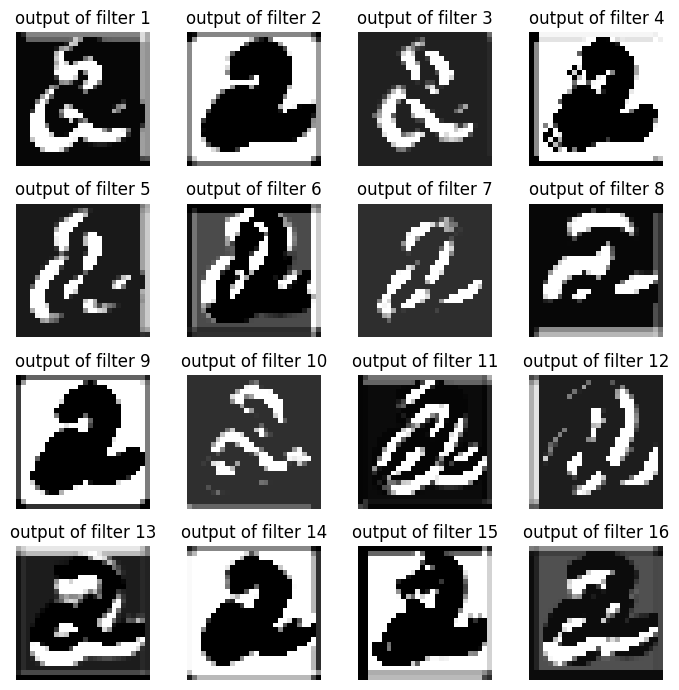

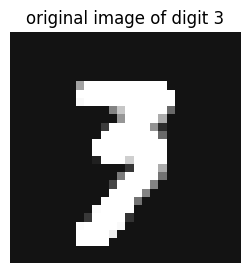

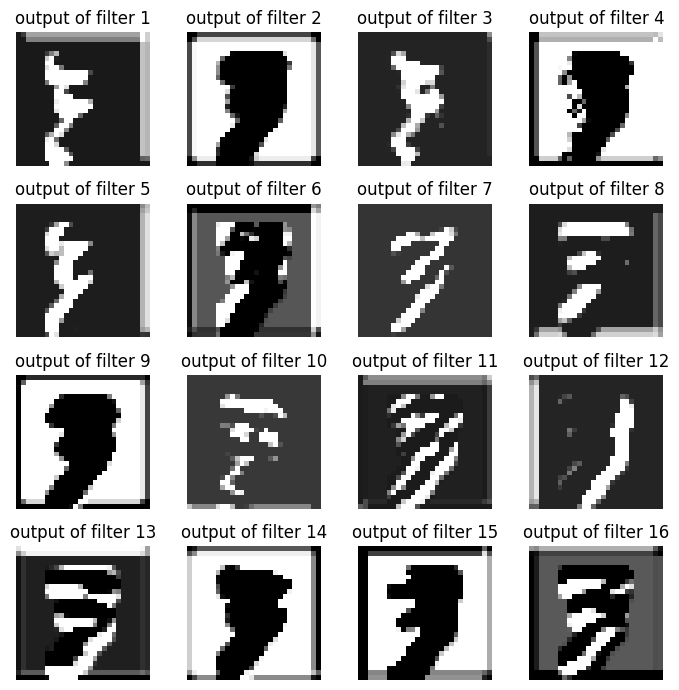

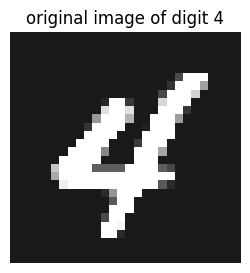

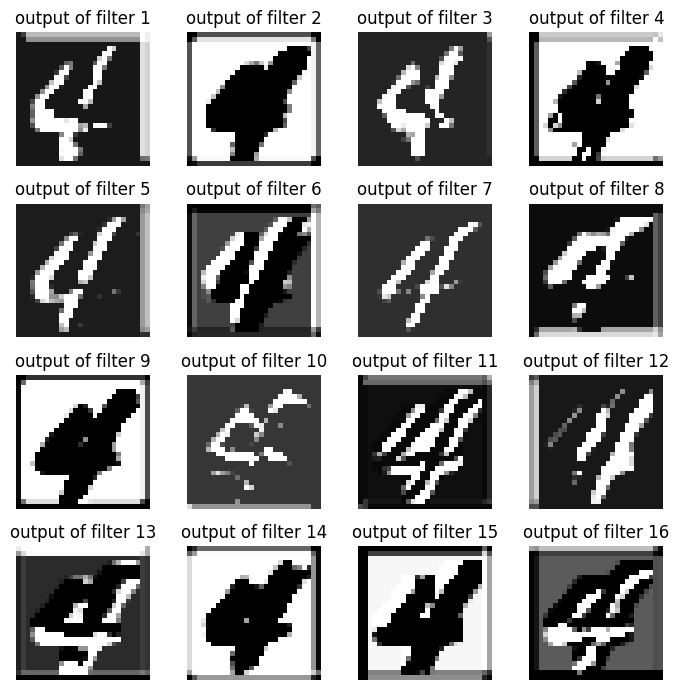

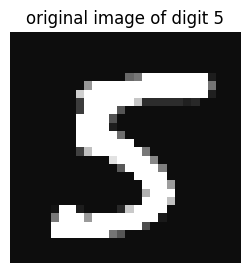

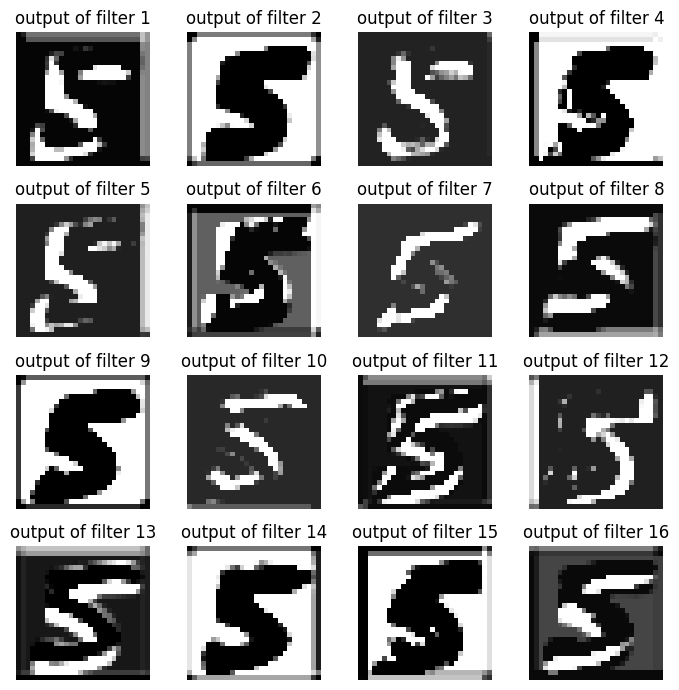

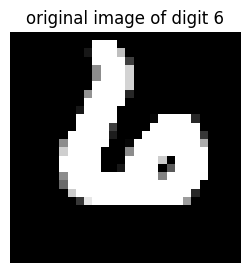

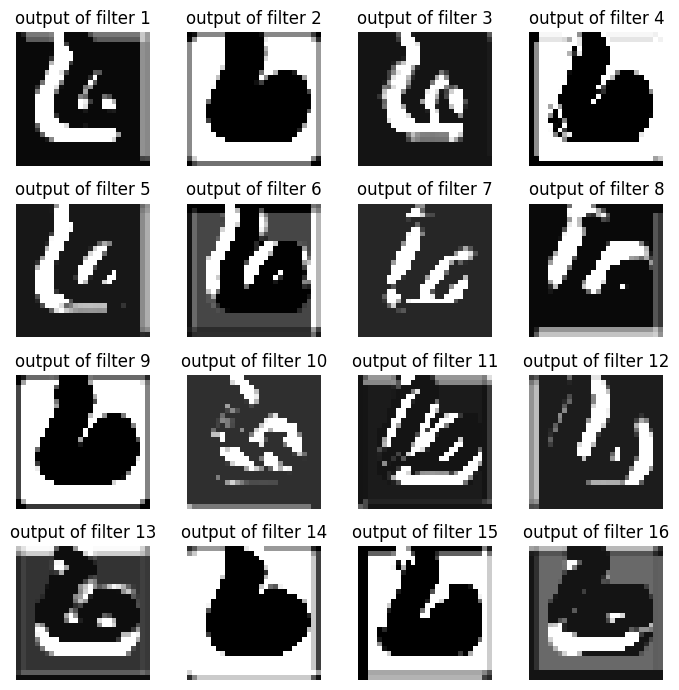

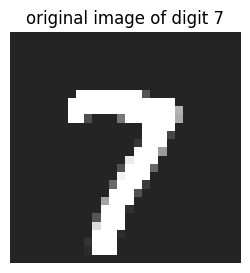

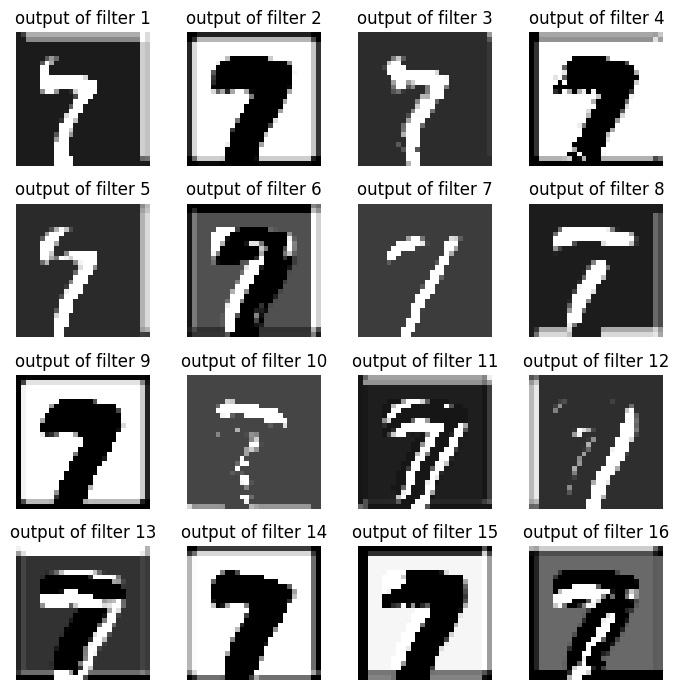

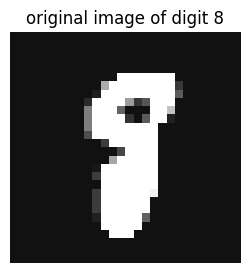

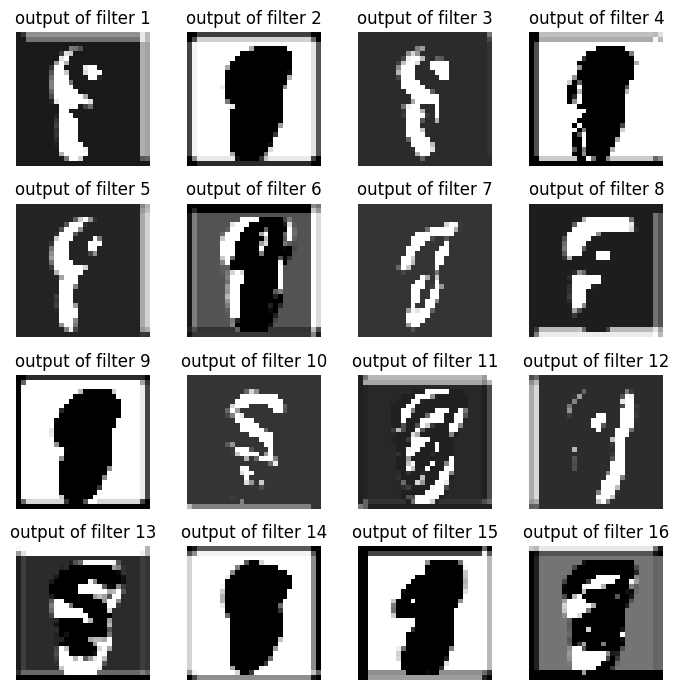

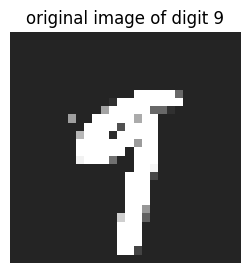

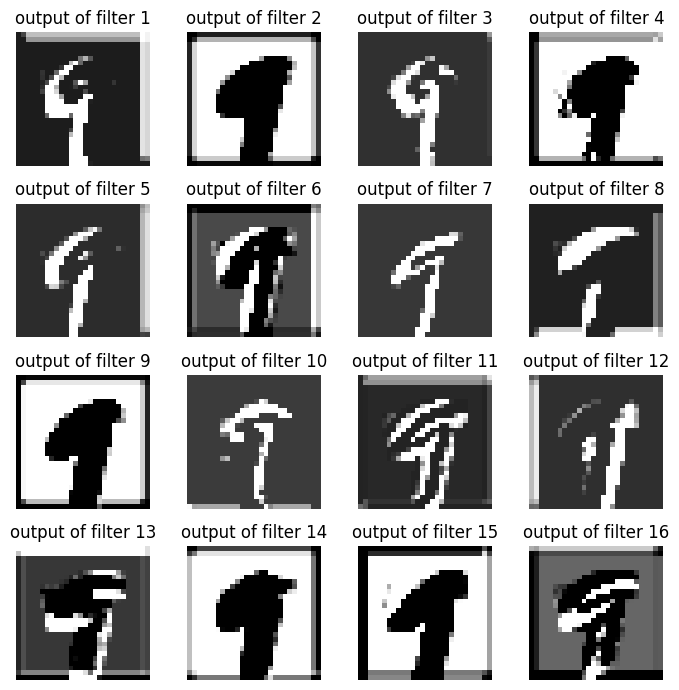

In [ ]:
# this code picks one sample from each label (each digit) for visualizing purposes
sample_digits = dict()
for data in train_loader:
    for i in range(data[1].shape[0]):
        if data[1][i].item() not in sample_digits.keys():
            sample_digits[data[1][i].item()]=data[0][i]
    if len(sample_digits.keys())==10:
        break

for digit in range(10):

    data = sample_digits[digit]
    npimg = data[0].numpy()
    npimg = normalize_image(npimg)
    plt.figure(figsize=(3,3))
    plt.imshow(npimg,cmap="gray",vmin=0,vmax=1)
    plt.title("original image of digit %d"%digit)
    plt.axis("off")

    with torch.no_grad():
        data = data.unsqueeze(0).to(device)
        # data has shape (1,1,28,28)
        # pass the data to only layer conv1 and apply RELU activation (do not apply maxpooling)
        # the output should be a tensor of size (1,32,28,28)
        output_pre_relu = net.conv1(data) # ACT 26.1: pass the data through the convolutional kernels
        output = torch.relu(output_pre_relu) # ACT 26.2: pass the previous output to relu

    data_numpy = output.detach().cpu().numpy()
    fig, axes = plt.subplots(4, 4, figsize=(7, 7))
    for i in range(16):
        npimg = data_numpy[0,i]
        npimg = normalize_image(npimg)
        axes[i//4, i%4].imshow(npimg,cmap="gray",vmin=0,vmax=1)
        axes[i//4, i%4].set_title("output of filter "+str(i+1))
        axes[i//4, i%4].axis('off')
    plt.tight_layout()
    plt.show()

    ###ASSERTS
    assert(data.size()==(1,1,28,28))
    assert(output.size()==(1,16,28,28))

**ACT27**
**What is the term (mentioned in lecture) that describes these images.**

**ANSWER**: Edge Detection

### Comparing with a Fully Connected Neural Network (ACT28-31)

Let's make a fully connected (FC) neural network with a similar number of parameters as your ConvNet. Then, we can compare the performance between the FC net and the ConvNet.

We have seen from above that the ConvNet has 120382 parameters. Now lets construct a FC network of similar size and train the network in an identical way using the trainer framework we have constructed above.


**ACT28**

Suppose we want a network with 3 hidden layers with dimension d, find d such that the total number of parameters is similar to the ConvNet (120000-130000).

In [ ]:
d = 120 # ACT 28 Find d such that the total number of parameters of FCNet is around 120000-130000

class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.input_size = 28 * 28
        self.fc1 = nn.Linear(self.input_size, d)
        self.fc2 = nn.Linear(d, d)
        self.fc3 = nn.Linear(d, d)
        self.fc4 = nn.Linear(d, 10)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

count_parameters(FCNet())

fc1.weight:	 torch.Size([120, 784])
fc1.bias:	 torch.Size([120])
fc2.weight:	 torch.Size([120, 120])
fc2.bias:	 torch.Size([120])
fc3.weight:	 torch.Size([120, 120])
fc3.bias:	 torch.Size([120])
fc4.weight:	 torch.Size([10, 120])
fc4.bias:	 torch.Size([10])
Total parameters: 124450


**ACT 29**

Follow the same way as you trained the ConvNet in ACT 16, train the FCNet using the same learning rate and number of epochs, save the stats to `stats_fc`

In [ ]:
# ACT 29
num_epochs = 10
learning_rate = 0.05 # The same learning rate as in ACT 16

net_fc = FCNet().to(device) # Initialize the network and send it to device
opt_fc = optim.SGD(net_fc.parameters(), lr = learning_rate)# Define the optimizer using same hyperparameter as in ACT 16
loss_function = nn.CrossEntropyLoss() # Define the cross entropy loss objective

trainer_fc = Trainer(net_fc, opt_fc, loss_function, train_loader, test_loader) # Initialize the trainer for FCNet

stats_fc = trainer_fc.train(num_epochs) # Train the model using trainer_fc and save the stats

Testing: 100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch 1: train loss 1.0271, train acc 70.54%, test loss 0.3504, test acc 89.81%



Testing: 100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 2: train loss 0.3219, train acc 90.54%, test loss 0.2648, test acc 92.09%



Testing: 100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


Epoch 3: train loss 0.2467, train acc 92.69%, test loss 0.2190, test acc 93.54%



Testing: 100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 4: train loss 0.1979, train acc 94.20%, test loss 0.1991, test acc 93.85%



Testing: 100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Epoch 5: train loss 0.1651, train acc 95.18%, test loss 0.1526, test acc 95.60%



Testing: 100%|██████████| 40/40 [00:02<00:00, 14.17it/s]


Epoch 6: train loss 0.1391, train acc 95.89%, test loss 0.1398, test acc 95.85%



Testing: 100%|██████████| 40/40 [00:02<00:00, 13.71it/s]


Epoch 7: train loss 0.1214, train acc 96.41%, test loss 0.1285, test acc 96.08%



Testing: 100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Epoch 8: train loss 0.1078, train acc 96.83%, test loss 0.1302, test acc 95.89%



Testing: 100%|██████████| 40/40 [00:02<00:00, 14.98it/s]


Epoch 9: train loss 0.0951, train acc 97.16%, test loss 0.1052, test acc 96.72%



Testing: 100%|██████████| 40/40 [00:02<00:00, 14.45it/s]

Epoch 10: train loss 0.0852, train acc 97.52%, test loss 0.1073, test acc 96.48%



**ACT30**

Visualize the training statistics following ACT 19 and 20

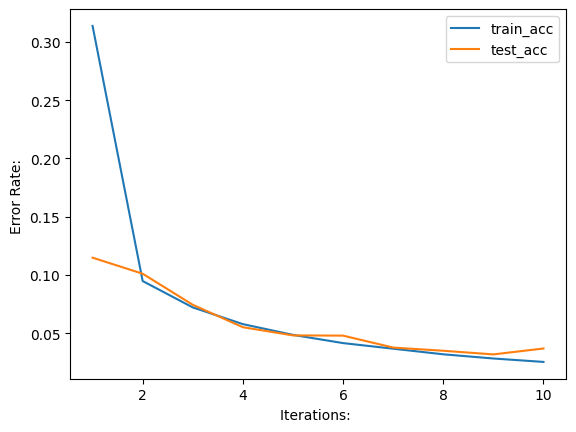

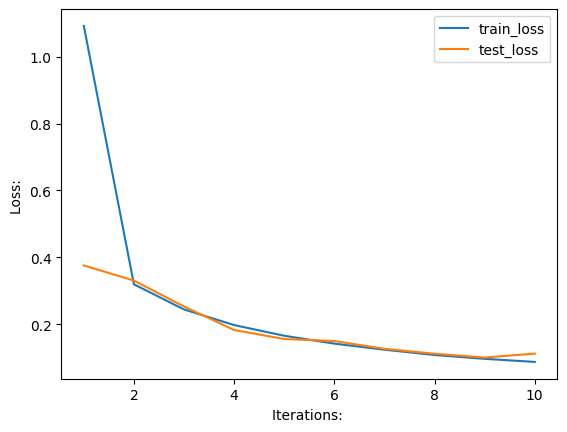

In [32]:
### ACT30.1
plt.figure()
plt.xlabel("Iterations: ")
plt.ylabel("Error Rate: ")
iterations = np.arange(1, len(stats_fc['train_loss']) + 1)

ones = np.ones(len(stats_fc['train_loss']))
plt.plot(iterations, ones - stats_fc['train_acc'], label = 'train_acc')
plt.plot(iterations, ones - stats_fc['test_acc'], label = 'test_acc')
plt.legend()

### ACT30.2
plt.figure()
plt.xlabel("Iterations: ")
plt.ylabel("Loss: ")
plt.plot(iterations, stats_fc['train_loss'], label = 'train_loss')
plt.plot(iterations, stats_fc['test_loss'], label = 'test_loss')
plt.legend()

**ACT31**
**In 1-2 sentences explain why Fully Connected Layer performs better or worse than CNN.**

**ANSWER**: Fully Connected Layer performs worse than CNN because FCL ignores
the important spatial information of the pixels (surronding pixels) and key
patterns of the images that a CNN takes into account.